<a href="https://colab.research.google.com/github/hecshzye/crypto-price-predictions-2022/blob/main/crypto_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  💲 Bitcoin Price Prediction using Deep Learning 💲

- Time series forecasting using TensorFlow to predict the price of Bitcoin (BTC) 

- The dataset used in this project is from CoinDesk: https://www.coindesk.com/price/bitcoin/

- Link to the dataset used (2014/03/11-2022/01/18): https://raw.githubusercontent.com/hecshzye/crypto-price-predictions-2022/main/BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv


- **`LEGAL NOTE`** ⚠️
     
     - **`Bitcoin (BTC) Price Prediction Using Deep Learning` project and its   `findings, conclusions and models` are `STRICTLY NOT FINANCIAL ADVICE` in any manner.**

     - **`ANY FINDINGS AND PREDICTIONS DERIVED FROM THIS MODEL IS ONLY FOR EDUCATIONAL, LEARNING AND RESEARCH PURPOSES`.**


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import tensorflow as tf
import csv
import datetime

In [2]:
# helper function pre-written
!wget https://raw.githubusercontent.com/hecshzye/crypto-price-predictions-2022/main/helper_functions.py

--2022-01-26 23:54:51--  https://raw.githubusercontent.com/hecshzye/crypto-price-predictions-2022/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6442 (6.3K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   6.29K  --.-KB/s    in 0s      

2022-01-26 23:54:51 (61.1 MB/s) - ‘helper_functions.py’ saved [6442/6442]



In [3]:
from helper_functions import create_tensorboard_callback, create_confusion_matrix, plot_loss_curves

# Data import and Exploratory Data Analysis 

In [4]:
# dataset import
!wget https://raw.githubusercontent.com/hecshzye/crypto-price-predictions-2022/main/BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv

--2022-01-26 23:54:52--  https://raw.githubusercontent.com/hecshzye/crypto-price-predictions-2022/main/BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156982 (153K) [text/plain]
Saving to: ‘BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv’

BTC_USD_2014-11-04_ 100%[===================>] 153.30K  --.-KB/s    in 0.02s   

2022-01-26 23:54:52 (6.91 MB/s) - ‘BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv’ saved [156982/156982]



In [5]:
df = pd.read_csv("/content/BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head(10), df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2633 entries, 2014-11-04 to 2022-01-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2633 non-null   object 
 1   Closing Price (USD)  2633 non-null   float64
 2   24h Open (USD)       2633 non-null   float64
 3   24h High (USD)       2633 non-null   float64
 4   24h Low (USD)        2633 non-null   float64
dtypes: float64(4), object(1)
memory usage: 123.4+ KB


(           Currency  Closing Price (USD)  ...  24h High (USD)  24h Low (USD)
 Date                                      ...                               
 2014-11-04      BTC           324.467934  ...      333.539527     323.106623
 2014-11-05      BTC           328.644408  ...      330.671610     320.902900
 2014-11-06      BTC           337.921358  ...      342.384170     328.597125
 2014-11-07      BTC           348.992860  ...      352.585895     336.236830
 2014-11-08      BTC           341.459753  ...      351.651854     340.196145
 2014-11-09      BTC           344.745289  ...      346.475560     340.357542
 2014-11-10      BTC           357.239982  ...      357.986991     342.082083
 2014-11-11      BTC           371.116917  ...      371.116917     371.116917
 2014-11-12      BTC           366.664633  ...      370.800015     361.225098
 2014-11-13      BTC           428.882925  ...      435.484664     366.598986
 
 [10 rows x 5 columns], None)

In [6]:
len(df)

2633

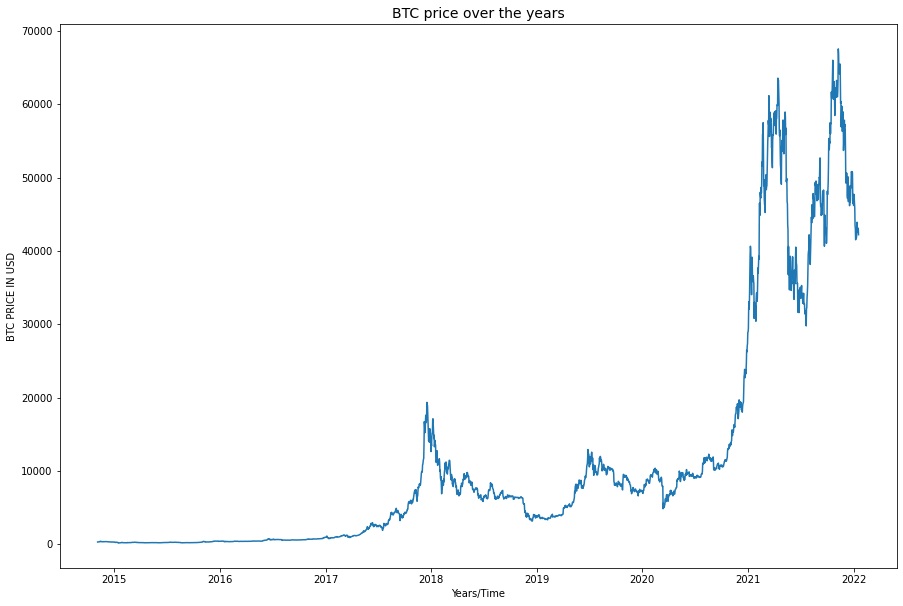

In [7]:
# Importing, formatting and EDA
from datetime import datetime
timesteps = []
btc_price = []
with open("/content/BTC_USD_2014-11-04_2022-01-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# Plotting 
plt.figure(figsize=(15, 10))
plt.plot(timesteps, btc_price)
plt.title("BTC price over the years", fontsize=14)
plt.ylabel("BTC PRICE IN USD")
plt.xlabel("Years/Time");

In [8]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})

In [9]:
# Function for plots
def plot_ts(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time scale")
  plt.ylabel("BTC Price in USD")
  if label:
    plt.legend(fontsize=12)
  plt.grid(False)  

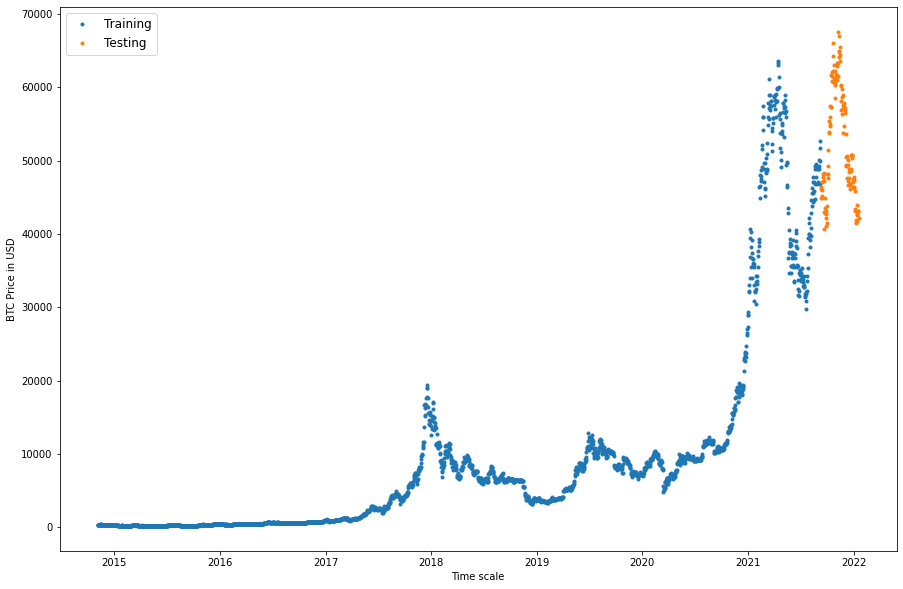

In [10]:
# Splitting Train & Test
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
split_size = int(0.95 * len(prices))
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

# Plotting the split
plt.figure(figsize=(15, 10))
plot_ts(timesteps=X_train, values=y_train, label="Training")
plot_ts(timesteps=X_test, values=y_test, label="Testing")

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2501, 132, 2501, 132)

**Training data** = `2501`

**Testing data** = `132`

# Modelling

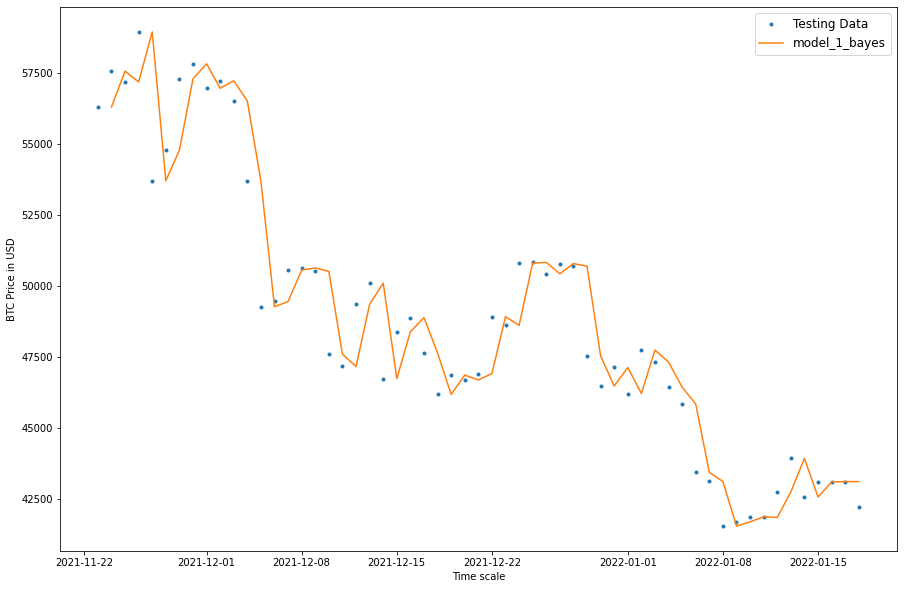

In [12]:
# Preprocessing for Bayes' model_1 without training
model_1_bayes = y_test[:-1]

# Plotting model_1_bayes
plt.figure(figsize=(15, 10))
offset = 75
plot_ts(timesteps=X_test, values=y_test, start=offset, label="Testing Data")
plot_ts(timesteps=X_test[1:], values=model_1_bayes, format="-", start=offset, label="model_1_bayes");

**model_1_bayes without training using Naïve Bayes statistical modelling**

In [13]:
# Function for evaluation with mean absolute scaled error
def mase_func(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mase_func(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}
         
# Evaluation for model_1_bayes
model_1_bayes_results = evaluate_preds(y_true=y_test[1:],
                                       y_pred=model_1_bayes)
model_1_bayes_results        


{'mae': 1318.5054,
 'mape': 2.5244212,
 'mase': 0.9941498,
 'mse': 3049834.0,
 'rmse': 1746.3774}

In [14]:
tf.reduce_mean(y_test).numpy()

52390.154000378796

**model_1_bayes** is on average off by `$1318` 

The average value of $BTC is on test dataset is `$52,390`

# model_2 with Windows

In [15]:
# Preprocessing for model_2
HORIZON = 1
# A week for timessteps
WINDOW_SIZE = 7

# Function for labelling 
def window_labelling(x, horizon=1):
  return x [:, :-horizon], x[:, -horizon:]

# Function which helps to process numpy arrays as windows
def create_window(x, window_size=7, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  window_array = x[window_indexes]
  windows, labels = window_labelling(window_array, horizon=horizon)
  return windows, labels

full_windows, full_labels = create_window(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels) 


(2626, 2626)

In [16]:
# Windowed arrays (from first and last)
for i in range(3):
  print(f"Window(from first): {full_windows[i]} >>> Label: {full_labels[i]}")
  print(f"Window(from last): {full_windows[i-3]} >>> Label: {full_labels[i-3]}")  

Window(from first): [324.467934 328.644408 337.921358 348.99286  341.459753 344.745289
 357.239982] >>> Label: [371.116917]
Window(from last): [41687.227593 41861.803632 41838.40628  42737.637061 43921.81
 42558.937409 43090.200356] >>> Label: [43104.686581]
Window(from first): [328.644408 337.921358 348.99286  341.459753 344.745289 357.239982
 371.116917] >>> Label: [366.664633]
Window(from last): [41861.803632 41838.40628  42737.637061 43921.81     42558.937409
 43090.200356 43104.686581] >>> Label: [43102.957367]
Window(from first): [337.921358 348.99286  341.459753 344.745289 357.239982 371.116917
 366.664633] >>> Label: [428.882925]
Window(from last): [41838.40628  42737.637061 43921.81     42558.937409 43090.200356
 43104.686581 43102.957367] >>> Label: [42223.860989]


In [17]:
# Function for splitting training and testing for model_2
def train_test_split(windows, labels, test_split=0.02):
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels
train_windows, test_windows, train_labels, test_labels = train_test_split(full_windows, full_labels)

# Function for checkpoints 
def model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

# Modelling model_2
from tensorflow.keras import layers
tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
   layers.Dense(128, activation="relu"),
   layers.Dense(HORIZON, activation="linear")                               
], name="model_2_dense")
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[model_checkpoint(model_name=model_2.name)])

Epoch 1/100
21/21 [==============================] - 3s 111ms/step - loss: 2384.3718 - mae: 2384.3718 - val_loss: 5131.4624 - val_mae: 5131.4624
Epoch 2/100
21/21 [==============================] - 1s 69ms/step - loss: 685.2910 - mae: 685.2910 - val_loss: 3419.3157 - val_mae: 3419.3157
Epoch 3/100
21/21 [==============================] - 1s 65ms/step - loss: 532.3688 - mae: 532.3688 - val_loss: 1711.4756 - val_mae: 1711.4756
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 499.2782 - mae: 499.2782 - val_loss: 2566.0439 - val_mae: 2566.0439
Epoch 5/100
21/21 [==============================] - 2s 85ms/step - loss: 500.7531 - mae: 500.7531 - val_loss: 1653.6050 - val_mae: 1653.6050
Epoch 6/100
21/21 [==============================] - 0s 6ms/step - loss: 492.6534 - mae: 492.6534 - val_loss: 2427.7532 - val_mae: 2427.7532
Epoch 7/100
21/21 [==============================] - 1s 63ms/step - loss: 488.8423 - mae: 488.8423 - val_loss: 1477.8048 - val_mae: 1477.8048
Epoch

In [19]:
# Evaluation
model_2.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 10ms/step - loss: 1183.7384 - mae: 1183.7384


[1183.7384033203125, 1183.7384033203125]

In [20]:
# Callbacks 
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

2/2 [==============================] - 0s 13ms/step - loss: 1183.7384 - mae: 1183.7384


[1183.7384033203125, 1183.7384033203125]

In [21]:
# Function for forecasting
def make_forecast(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)


model_2_preds = make_forecast(model_2, test_windows)
len(model_2_preds), model_2_preds[:20]  

(53, <tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([58750.023, 54641.293, 54637.156, 56794.883, 57932.438, 57221.617,
        57407.816, 56916.527, 54303.848, 49888.293, 49108.87 , 50040.86 ,
        50425.293, 50428.25 , 48159.586, 47271.797, 48913.1  , 50037.906,
        47385.98 , 48149.176], dtype=float32)>)

model_2 predictions on the test dataset have a Mean Absolute Error of $1183.73 